In [1]:
import pandas as pd
import numpy as np
import gc
import re
import MeCab
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim import corpora
model = Word2Vec.load('/tmp/content_based_word2vec_model')

In [2]:
corpus = np.load('corpus_dealonly.npy')
from gensim import corpora
dictionary = corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below=5, no_above=1, keep_n=300000, keep_tokens=None)
corpus_dict = [dictionary.doc2bow(text) for text in corpus]
tfidf = TfidfModel(corpus_dict)

# contents_based itemvec

In [123]:
deal_path = 'kddi_r_deal.tsv_20180328.gz'
deal_profile_path = 'kddi_r_deal_profile_20180427.tsv.gz'
work_path = '/home/mmde-lab/s3/59e875d818c7b/'
order_path = 'kddi_r_pay_order.tsv.gz'
df_order = pd.read_csv(work_path + order_path, sep = '\t', compression='gzip')
df_deal = pd.read_csv(work_path + deal_path, sep = '\t', compression='gzip')
df_dealprofile = pd.read_csv(work_path + deal_profile_path, sep = '\t', compression='gzip')

/home/mmde-lab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (9,14,15,51,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mmde-lab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10,13,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [124]:
pattern = re.compile(r'<(.*?)>')
df_dealprofile.deal_description = df_dealprofile.deal_description.map(lambda x: str(re.sub(pattern, '', str(x))))
mecab = MeCab.Tagger('-Ochasen')
def rawdcrp2tokendcrp(rawdescription):
    deal_des = []
    for line in rawdescription:
        tokenlst = mecab.parse(line)
        pattern1 = re.compile(r'(.*?)(名詞|動詞|形容詞)(.*?)')
        new_dcp1 = pattern1.findall(tokenlst)
        pattern2 = re.compile('(.*?)\t')
        sentence_des = []
        for token in range(len(new_dcp1)):
            matchobjdes = re.match(pattern2, new_dcp1[token][0])
            if(matchobjdes != None):
                sentence_des.append(matchobjdes.group(1))
        deal_des.append(sentence_des)
    return deal_des
df_dealprofile.deal_description = df_dealprofile.deal_description.map(lambda x: x.split('。'))
df_dealprofile.deal_description = df_dealprofile.deal_description.map(lambda x: rawdcrp2tokendcrp(x)) 

In [125]:
df_deal = df_deal[['deal_id', 'deal_category_cd']]
df_dealprofile = df_dealprofile[['deal_id', 'deal_description']]

In [126]:
df_new = pd.merge(df_dealprofile, df_deal, on='deal_id')

In [127]:
df_new.isnull().sum()

deal_id             0
deal_description    0
deal_category_cd    0
dtype: int64

In [128]:
def calcu_des2vec(raw_des):
    deal_corpus = [dictionary.doc2bow(text) for text in raw_des]
    itemvec = np.zeros([1,200], dtype = float)
    for i in range(len(raw_des)):
        for j in range(len(deal_corpus[i])):
            itemvec += tfidf[deal_corpus][i][j][1]*model[dictionary.get(deal_corpus[i][j][0])]
    return itemvec

In [129]:
df_new['dealvec'] = df_new.deal_description.map(lambda x: calcu_des2vec(x))

/home/mmde-lab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [130]:
df_new.to_csv('df_new_mincount2.csv.gz', compression = 'gzip')

In [131]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

In [132]:
X, y = df_new.dealvec.values, df_new.deal_category_cd.values

In [133]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=816)

In [134]:
for line in range(len(X)):
    if(len(X[line]) != 200):
        X[line] = X[line][0]

In [135]:
X = np.concatenate(X, axis=0)

In [136]:
X = X.reshape([69295,200])

In [137]:
X_tsne = tsne.fit_transform(X)

In [138]:
from sklearn import preprocessing

In [139]:
le = preprocessing.LabelEncoder()

In [140]:
le.fit(y)

LabelEncoder()

In [208]:
y_int = le.transform(y)

In [166]:
for colors in range(len(y_int)):
    if y_int[colors]!= 11:
        y_int[colors] = 12

In [209]:
y_int

array([6, 6, 6, ..., 9, 1, 1])

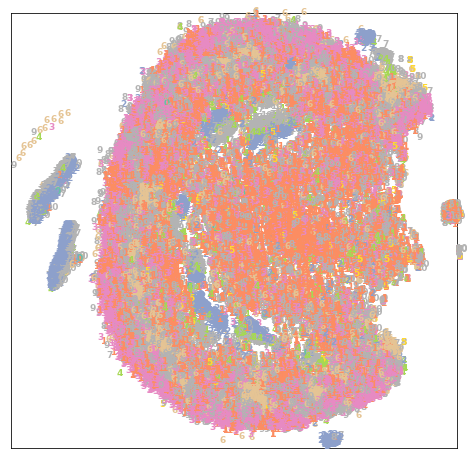

In [210]:
'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y_int[i]), color=plt.cm.Set2(y_int[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

------------69294------------


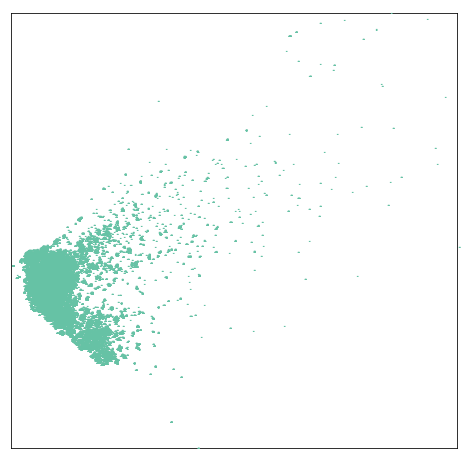

------------------------
------------69294------------


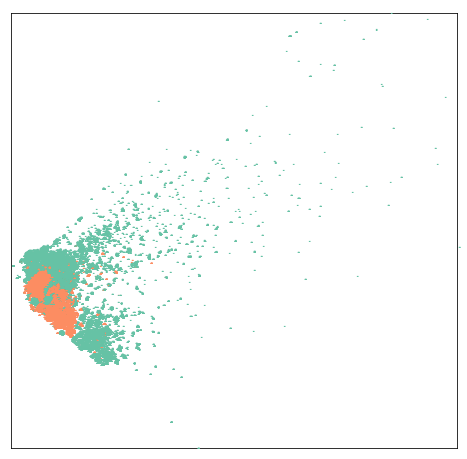

------------------------
------------69294------------


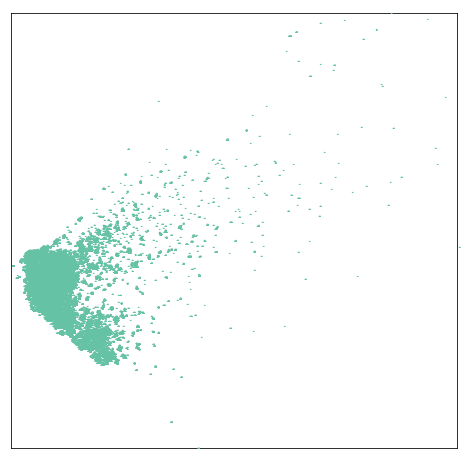

------------------------
------------69294------------


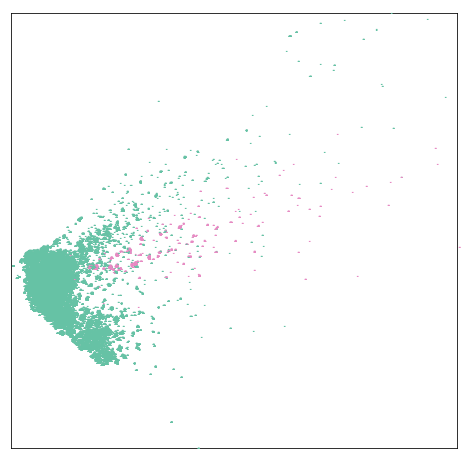

------------------------
------------69294------------


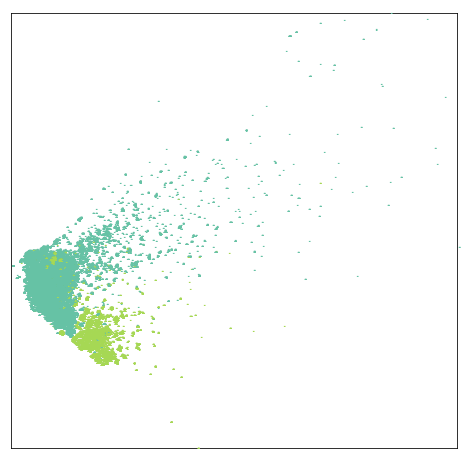

------------------------
------------69294------------


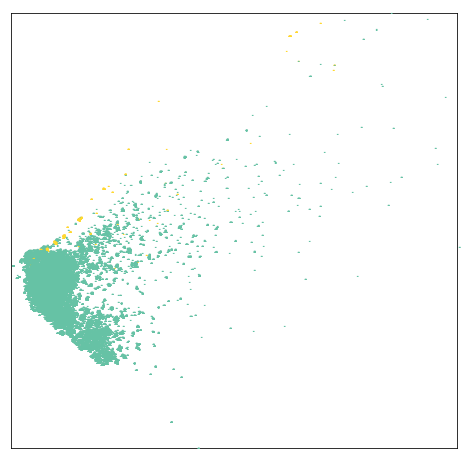

------------------------
------------69294------------


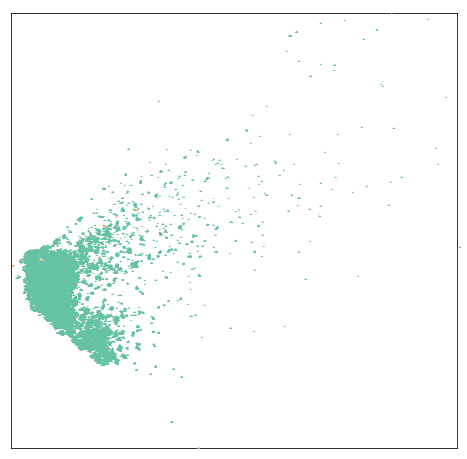

------------------------
------------69294------------


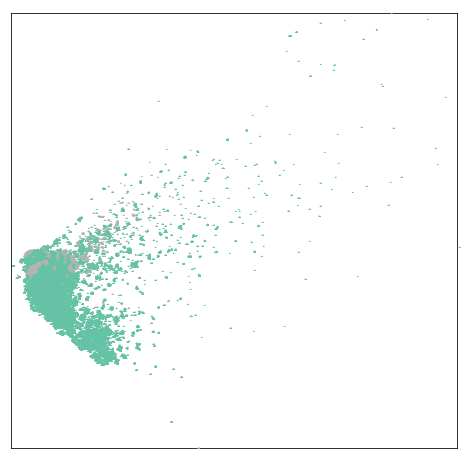

------------------------
------------69294------------


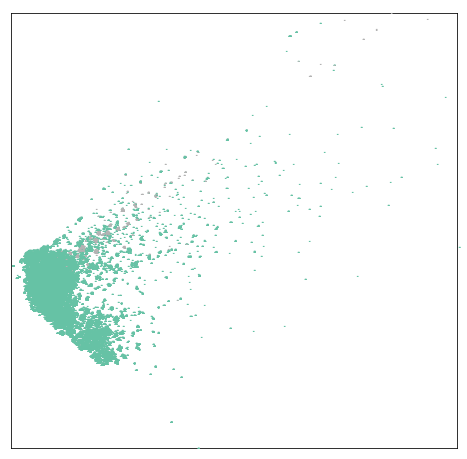

------------------------
------------69294------------


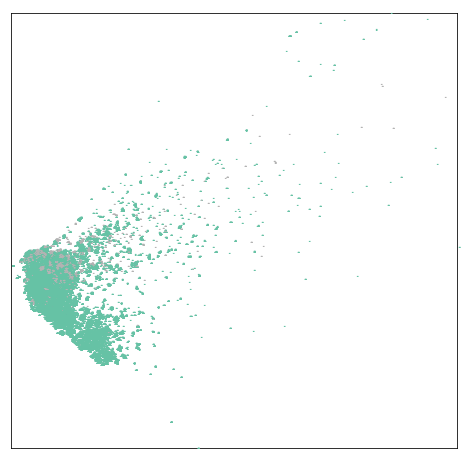

------------------------
------------69294------------


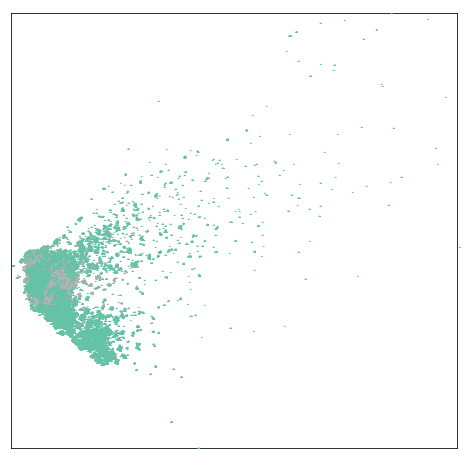

------------------------
------------69294------------


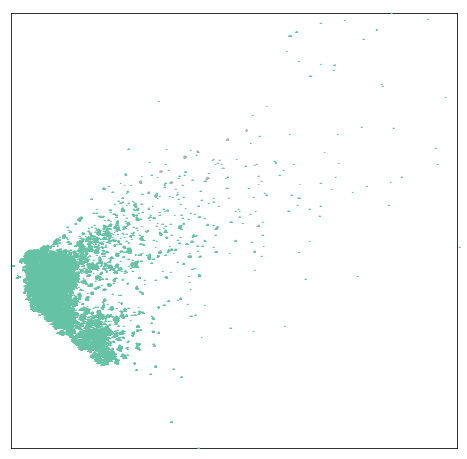

------------------------


In [172]:
for i in range(12):
    y_int = le.transform(y)
    for colors in range(len(y_int)):
        if y_int[colors]!= i:
            y_int[colors] = 0
    '''嵌入空间可视化'''
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(8, 8))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], '.', color=plt.cm.Set2(y_int[i]), 
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    print('------------' + str(i) + '------------')
    plt.show()
    print('------------------------')

In [28]:
le.classes_

array(['ACT', 'APR', 'ASM', 'BTY', 'CSM', 'ENT', 'ETC', 'GRD', 'GRM',
       'HEL', 'LFS', 'TRV'], dtype=object)

In [33]:
le.transform(['ACT', 'APR', 'ASM', 'BTY', 'CSM', 'ENT', 'ETC', 'GRD', 'GRM',
       'HEL', 'LFS', 'TRV'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [59]:
df_new.deal_category_cd.value_counts()

APR    23597
CSM    13646
LFS    11523
GRD     7279
HEL     5476
ETC     3003
BTY     1922
GRM     1843
ENT      699
TRV      288
ACT       17
ASM        2
Name: deal_category_cd, dtype: int64

# session_based_itemvec

In [ ]:
import pandas as pd
import numpy as np
import gc
import re
import MeCab
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim import corpora
model = Word2Vec.load('/tmp/session_based_word2vec__model')

In [ ]:
corpus = np.load('session_based_corpus.npy')
from gensim import corpora
dictionary = corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below=5, no_above=1, keep_n=300000, keep_tokens=None)
corpus_dict = [dictionary.doc2bow(text) for text in corpus]
tfidf = TfidfModel(corpus_dict)

In [175]:
deal_path = 'kddi_r_deal.tsv_20180328.gz'
deal_profile_path = 'kddi_r_deal_profile_20180427.tsv.gz'
work_path = '/home/mmde-lab/s3/59e875d818c7b/'
order_path = 'kddi_r_pay_order.tsv.gz'
df_order = pd.read_csv(work_path + order_path, sep = '\t', compression='gzip')
df_deal = pd.read_csv(work_path + deal_path, sep = '\t', compression='gzip')
df_dealprofile = pd.read_csv(work_path + deal_profile_path, sep = '\t', compression='gzip')

/home/mmde-lab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (9,14,15,51,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mmde-lab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10,13,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [176]:
sell_count = df_order.deal_id.value_counts()
sell = pd.DataFrame(sell_count)
sell = sell.rename(columns= {'deal_id':'sell_count'})
sell = sell.reset_index()
sell.columns = ['deal_id','sell_count']

In [177]:
def calcu_item2vec(raw_des):
    itemvec = np.zeros([1,200], dtype = float)
    itemvec = model[str(raw_des)]
    return itemvec

In [178]:
sell['dealvec'] = sell.deal_id.map(lambda x: calcu_item2vec(x))

/home/mmde-lab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [179]:
df_deal = df_deal[['deal_id', 'deal_category_cd']]

In [180]:
df_new = pd.merge(sell, df_deal, on='deal_id')

In [181]:
df_new.to_csv('df_new_session_based_window2.csv.gz', compression = 'gzip')

In [182]:
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

In [183]:
X, y = df_new.dealvec.values, df_new.deal_category_cd.values

In [184]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=816)

In [185]:
for line in range(len(X)):
    if(len(X[line]) != 200):
        X[line] = X[line][0]

In [186]:
X = np.concatenate(X, axis=0)

In [187]:
X = X.reshape([68458,200])

In [188]:
X_tsne = tsne.fit_transform(X)

In [189]:
from sklearn import preprocessing

In [190]:
le = preprocessing.LabelEncoder()

In [191]:
le.fit(y)

LabelEncoder()

In [192]:
y_int = le.transform(y)

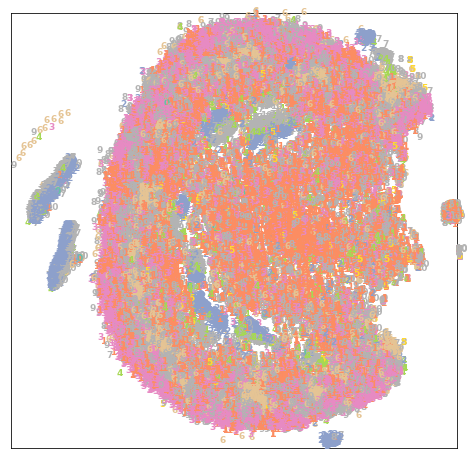

In [198]:
'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y_int[i]), color=plt.cm.Set2(y_int[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

In [200]:
le.classes_

array(['ACT', 'APR', 'BTY', 'CSM', 'ENT', 'ETC', 'GRD', 'GRM', 'HEL',
       'LFS', 'TRV'], dtype=object)

In [201]:
le.transform(['ACT', 'APR', 'BTY', 'CSM', 'ENT', 'ETC', 'GRD', 'GRM', 'HEL',
       'LFS', 'TRV'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [202]:
df_new.deal_category_cd.value_counts()

APR    21221
CSM    14146
LFS     9724
GRD     6767
HEL     5597
BTY     4818
GRM     3662
ENT     1387
TRV      626
ETC      462
ACT       48
Name: deal_category_cd, dtype: int64

------------0------------


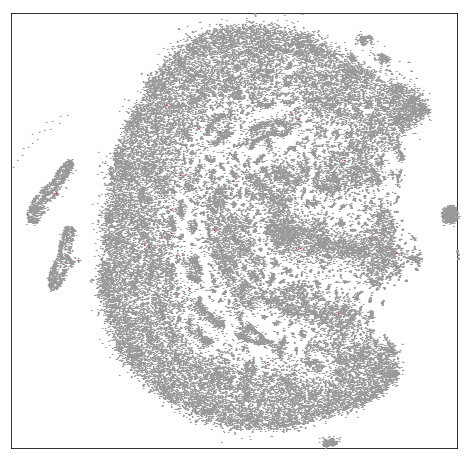

------------------------
------------1------------


KeyboardInterrupt: 

In [207]:
for j in range(11):
    y_int = le.transform(y)
    for colors in range(len(y_int)):
        if y_int[colors]!= j:
            y_int[colors] = 11
    '''嵌入空间可视化'''
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(8, 8))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], '.', color=plt.cm.Set1(float(y_int[i])), 
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    print('------------' + str(j) + '------------')
    plt.show()
    print('------------------------')